In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(1, '/viscam/projects/audio_nerf/transfer/audio_nerf/src')
import process
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
from diffusers import DiffusionPipeline
sys.path.insert(1, '/viscam/projects/audio_nerf/transfer/audio_nerf/riffusion-inference')
from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams
from riffusion.riffusion_pipeline import RiffusionPipeline
from riffusion.datatypes import InferenceInput
pipe = RiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")
pipe = pipe.to("cuda")
ref_data = np.load("/viscam/projects/audio_nerf/transfer/audio_nerf/data/processed_6s/reference.npy", mmap_mode='r')
im_data = np.load("/viscam/projects/audio_nerf/transfer/audio_nerf/data/processed_6s/imitations.npy", mmap_mode='r')
Audio(im_data[1003], rate=44100)

/viscam/u/ycda/miniconda3/envs/devoc/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/viscam/u/ycda/miniconda3/envs/devoc/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [1]:
!squeue -u ycda

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7675995 viscam-in     bash     ycda  R    4:55:14      1 viscam6


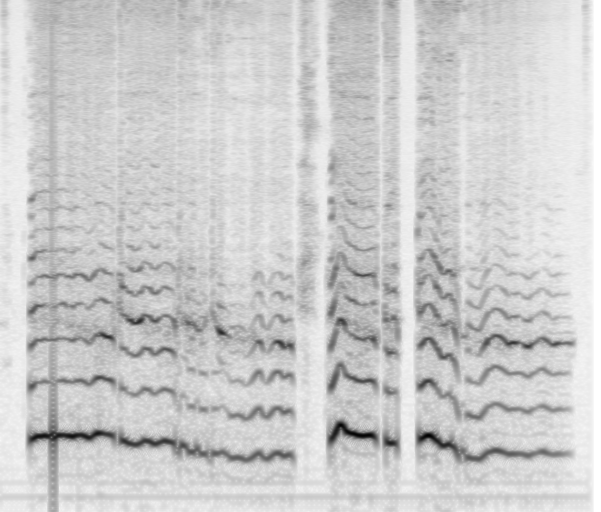

In [2]:
init_image, max_value = process.waveform_to_image(im_data[1003])
init_image

In [177]:
import pyreaper

#_, _, f0_times, f0_freqs, _ = pyreaper.reaper(np.int16(65536*im_data[1003]), fs=44100)
_, _, f0_times, f0_freqs, _ = pyreaper.reaper(np.int16(65536*y), fs=44100)

[autoreload of process failed: Traceback (most recent call last):
  File "/viscam/u/ycda/miniconda3/envs/devoc/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/viscam/u/ycda/miniconda3/envs/devoc/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/viscam/u/ycda/miniconda3/envs/devoc/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/viscam/projects/audio_nerf/transfer/audio_nerf/src/process.py", line 192
    def 
        ^
Sy

Residual symmetry: P:1829.148071  N:1950.621460  MEAN:-0.467026


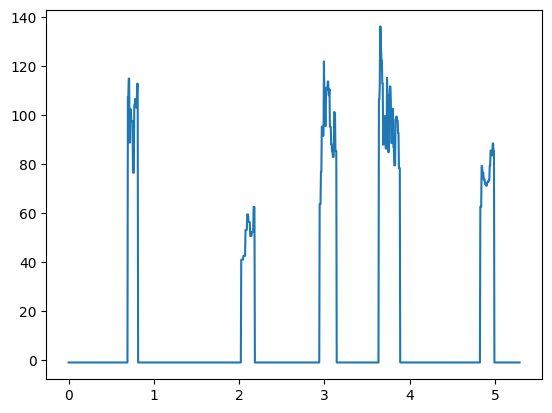

In [178]:
plt.plot(f0_times, f0_freqs)

In [179]:
harmonics = np.array([f0_freqs*i for i in range(1,40)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


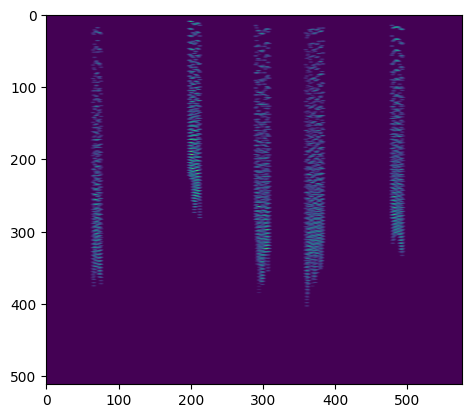

In [180]:
spec = np.zeros((512,576))
count = 0
for harmonic in harmonics:
    spec += process.gen_spectrogram(f0_times, harmonic)
    print(count)
    count += 1
plt.imshow(spec)

In [145]:
mask_spec = (spec==0).astype(np.float32)

In [146]:
mask_image, _ = process.image_from_spectrogram(mask_spec)

In [12]:
init_image, max_value = process.waveform_to_image(im_data[1003])

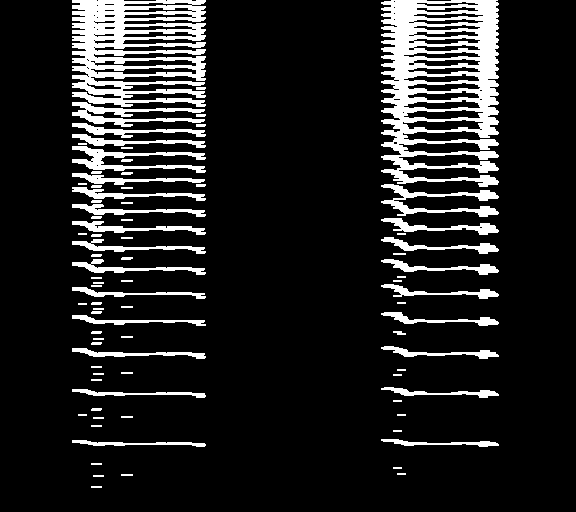

In [147]:
display(mask_image)

In [54]:
image = pipe.riffuse_mason("Turn this vocally imitated recording into a tuba",
                           init_image=init_image,
                           mask_image = mask_image,
                           num_inference_steps=50)[0]


  0%|          | 0/38 [00:00<?, ?it/s]

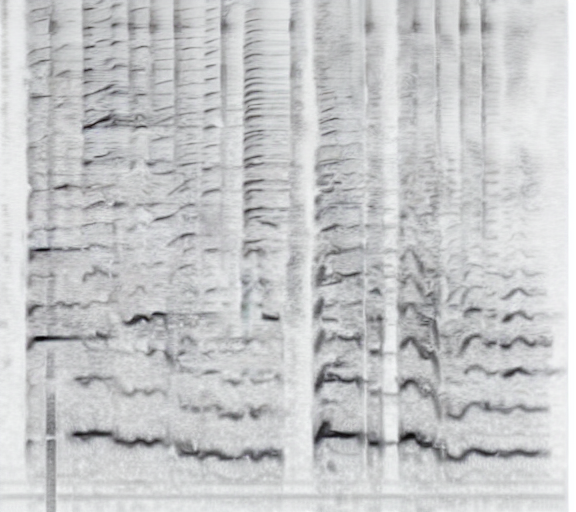

In [55]:
image

In [56]:
wave_out = process.image_to_waveform(image, max_value)
Audio(wave_out, rate=44100)

# Whistle

In [166]:
import scipy.io.wavfile
_, x = scipy.io.wavfile.read("DrumsImitation.wav")

/tmp/ycda/ipykernel_1205330/2410679437.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, x = scipy.io.wavfile.read("DrumsImitation.wav")


In [167]:
y = np.zeros(44100*6)
#y[:288224] = x[:44100*6]
y = x[:44100*6]
#y[:234560] = x

In [168]:
Audio(y, rate=44100)

In [172]:
init_image, max_value = process.waveform_to_image(y)
out_image = pipe.riffuse_mason("Drums",
                           init_image=init_image,
                           mask_image = None,
                           num_inference_steps=50,
                            negative_prompt="Voice",
                            )[0]

  0%|          | 0/38 [00:00<?, ?it/s]

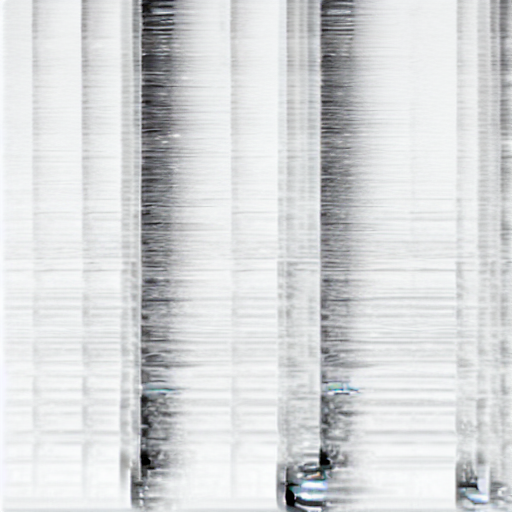

In [175]:
out_image

In [176]:
wave_out = process.image_to_waveform(out_image, max_value)
Audio(wave_out, rate=44100)